# Script 1 
## Detailed analysis of kidnappings in Colombia: Predictive modeling

* Pablo Alejandro Reyes Granados

****
 

# 1. Introduction  
****

## Database Context  
The SECUESTRO dataset comes from the Open Data portal of Colombia’s Ministry of National Defense and contains the monthly historical series of reported kidnapping incidents at the national level from January 1996 through June 2025. Each row of the dataset corresponds to a specific month and municipality, and includes the following key variables:

* **FECHA_HECHO**: date (year–month) of the event.  
* **DEPARTAMENTO and MUNICIPIO**: geographic location where the incident was reported.  
* **TIPO**: type of kidnapping (“simple” or “extortive”).  
* **TOTAL_CASOS**: number of cases recorded in that period and location.

This record is sourced from official reports by the National Police and GAULA (Unified Action Group for Personal Liberty), updated monthly with coverage across continental Colombia (excluding Providencia and San Andrés).

## Justification  
In Colombia, kidnapping has historically been one of the most prominent criminal modalities within the armed conflict (Centro Nacional de Memoria Histórica, 2020). A report by the NGO Pares (2025) indicates that 338 kidnappings were recorded in 2023—the highest figure in eight years—which not only violates victims’ fundamental rights but also discourages tourism and foreign investment, damages the country’s international image, and diverts resources toward predominantly military responses, limiting the effectiveness of prevention and economic recovery strategies.

## Analysis Objectives

1. **Conduct an exploratory and statistical analysis of the kidnapping series**  
   Develop descriptive statistics and visualization tools to identify trends, cycles, and structural breaks in kidnapping evolution, supplemented by geospatial analysis to map hotspots and shifts of the issue across the national territory.

2. **Integrate socioeconomic sources to study determinants**  
   Merge the kidnapping case series with guerrilla violence indicators to uncover correlations and spatial patterns. Additionally, measure each municipality’s institutional presence to better understand variation in crime incidence.

3. **Model dynamics and forecasting using econometrics and machine learning**  
   Fit econometric models (panel data regressions) and machine learning algorithms (boosting methods and fully connected neural networks) to capture the underlying series dynamics, assess predictive performance, and compare the effectiveness of different methodologies.  


****
# 2. Loading and Exploring the Main Dataset
****

### Librerias a usar 

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd
import ipywidgets as widgets
from IPython.display import display
from functools import partial
from statsmodels.tsa.seasonal import seasonal_decompose
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx


import sys
from pathlib import Path

scripts_dir = Path().resolve().parent / 'Scripts'
sys.path.insert(0, str(scripts_dir))
from construccion_bases_series import *

### Load the base DataFrame (df) of the kidnapping series

In [6]:
secuestros = pd.read_csv('../Datos/SECUESTRO_20250630.csv')
secuestros.head(10)

,FECHA HECHO,COD_DEPTO,DEPARTAMENTO,COD_MUNI,MUNICIPIO,TIPO DELITO,CANTIDAD
0,01/01/1996,5,ANTIOQUIA,5042,SANTAFE DE ANTIOQUIA,SECUESTRO SIMPLE,1
1,01/01/1996,25,CUNDINAMARCA,25290,FUSAGASUGA,SECUESTRO EXTORSIVO,1
2,02/01/1996,5,ANTIOQUIA,5038,ANGOSTURA,SECUESTRO EXTORSIVO,1
3,02/01/1996,68,SANTANDER,68001,BUCARAMANGA,SECUESTRO EXTORSIVO,1
4,02/01/1996,5,ANTIOQUIA,5088,BELLO,SECUESTRO EXTORSIVO,1
5,02/01/1996,11,BOGOTA D.C.,11001,BOGOTA D.C.,SECUESTRO EXTORSIVO,1
6,03/01/1996,11,BOGOTA D.C.,11001,BOGOTA D.C.,SECUESTRO EXTORSIVO,1
7,04/01/1996,63,QUINDIO,63001,ARMENIA,SECUESTRO EXTORSIVO,1
8,04/01/1996,18,CAQUETA,18592,PUERTO RICO,SECUESTRO EXTORSIVO,1
9,04/01/1996,5,ANTIOQUIA,5042,SANTAFE DE ANTIOQUIA,SECUESTRO EXTORSIVO,1


In [7]:
secuestros.columns

Index(['FECHA HECHO', 'COD_DEPTO', 'DEPARTAMENTO', 'COD_MUNI', 'MUNICIPIO',
       'TIPO DELITO', 'CANTIDAD'],
      dtype='object')

## **2.1 Analysis of the composition of the df**

#### **2.1.1 Number of observations and features**

In [4]:
secuestros.shape 

(28020, 7)

We have 28 thousand kidnapping records and 7 columns

#### **2.1.2 Data types of each feature**

In [5]:
secuestros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28020 entries, 0 to 28019
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FECHA HECHO   28020 non-null  object
 1   COD_DEPTO     28020 non-null  int64 
 2   DEPARTAMENTO  28020 non-null  object
 3   COD_MUNI      28020 non-null  int64 
 4   MUNICIPIO     28020 non-null  object
 5   TIPO DELITO   28020 non-null  object
 6   CANTIDAD      28020 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.5+ MB


#### **2.1.3 Identify missing data**

In [6]:
for i in secuestros.columns:
    if secuestros[i].isna().sum() > 0:
        print('Datos Faltantes en {i}')
    else:
        pass 
else:
    print('No hay datos faltantes')   

No hay datos faltantes


### **2.2 Construction of the monthly - quarterly and annual series with the help of the script `construccion_base_series.py`**

In [8]:
municipios_mensual , departamentos_mensual , municipios_anual , departamentos_anual  , serie_colombia_mensual = crear_series_de_tiempo(verificar_base , secuestros)

Fechas inválidas: 0


### Let's visualize the data we created

In [8]:
departamentos_mensual

,MES,COD_DEPTO,DEPARTAMENTO,N_SIMPLE,N_EXTORSIVO,TOTAL
0,1996-01-31,5,ANTIOQUIA,1,36,37
1,1996-01-31,8,ATLANTICO,0,5,5
2,1996-01-31,11,BOGOTA D.C.,0,8,8
3,1996-01-31,13,BOLIVAR,0,2,2
4,1996-01-31,15,BOYACA,0,2,2
...,...,...,...,...,...,...
5257,2025-04-30,5,ANTIOQUIA,0,10,10
5258,2025-04-30,19,CAUCA,1,2,3
5259,2025-04-30,20,CESAR,0,1,1
5260,2025-04-30,54,NORTE DE SANTANDER,2,0,2


In [9]:
departamentos_anual

,AÑO,COD_DEPTO,DEPARTAMENTO,N_SIMPLE,N_EXTORSIVO,TOTAL
0,1996-12-31,5,ANTIOQUIA,45,255,300
1,1996-12-31,8,ATLANTICO,0,26,26
2,1996-12-31,11,BOGOTA D.C.,4,58,62
3,1996-12-31,13,BOLIVAR,0,30,30
4,1996-12-31,15,BOYACA,1,4,5
...,...,...,...,...,...,...
798,2025-12-31,73,TOLIMA,0,1,1
799,2025-12-31,76,VALLE DEL CAUCA,1,10,11
800,2025-12-31,81,ARAUCA,13,2,15
801,2025-12-31,85,CASANARE,0,1,1


In [10]:
serie_colombia_mensual

,AÑO,N_SIMPLE,N_EXTORSIVO,TOTAL
0,1996-01-31,1,103,104
1,1996-02-29,1,76,77
2,1996-03-31,6,94,100
3,1996-04-30,15,72,87
4,1996-05-31,11,84,95
...,...,...,...,...
347,2024-12-31,5,22,27
348,2025-01-31,5,17,22
349,2025-02-28,6,22,28
350,2025-03-31,11,51,62


All the Dfs are what we were looking to create: Panels by municipality with kidnappings grouped by month and year. In addition, a Df for the total annual series.

****
# **3. Exploratory Analysis (EDA) for municipalities - departments and Colombia**
****

### **3.1 Time series analysis for the number of kidnappings at the country level**

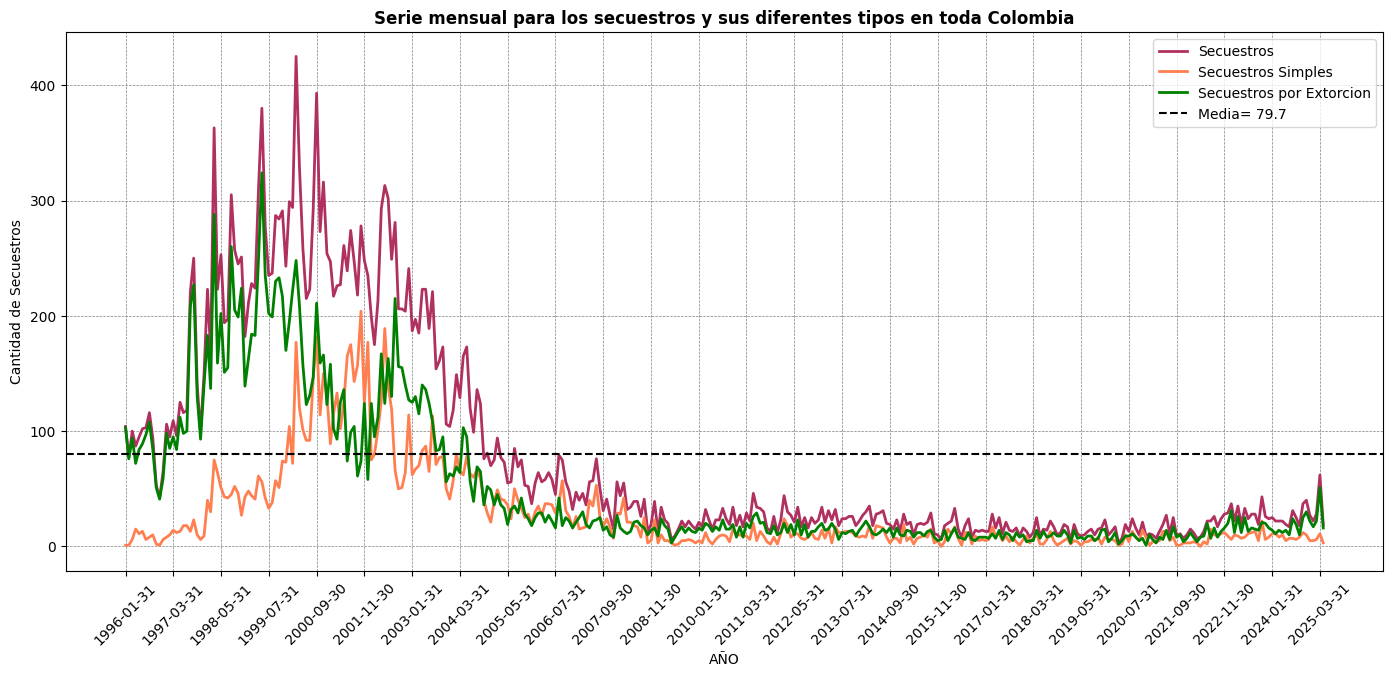

In [27]:
mean = serie_colombia_mensual['TOTAL'].mean()

plt.figure(figsize=(17, 7))    
plt.plot(serie_colombia_mensual['AÑO'], serie_colombia_mensual['TOTAL'] ,label="Secuestros", 
         linewidth=2 , color='#B03060')
plt.plot(serie_colombia_mensual['AÑO'], serie_colombia_mensual['N_SIMPLE'] ,label="Secuestros Simples", 
         linewidth=2 , color='#FF7F50')
plt.plot(serie_colombia_mensual['AÑO'], serie_colombia_mensual['N_EXTORSIVO'] ,label="Secuestros por Extorcion", 
         linewidth=2 , color='green')
plt.axhline(mean, color='black', linestyle='--', label='Media= 79.7')
cuartiles_a_mostrar = serie_colombia_mensual['AÑO'][::14]
plt.xticks(cuartiles_a_mostrar, rotation=45)
plt.xlabel('AÑO')
plt.ylabel('Cantidad de Secuestros')
plt.title('Serie mensual para los secuestros y sus diferentes tipos en toda Colombia' , weight='bold')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

The monthly evolution of kidnappings in Colombia reflects the main phases of the armed conflict:

- **1996–2001: Guerrilla and Paramilitary Surge**  
  The FARC and ELN exploited kidnapping to finance themselves and pressure the State—the infamous million-peso ransom kidnappings—while the AUC emerged using extortion. The curve shows peaks of over 300–400 kidnappings per month.

- **2002–2006: Paramilitary Demobilization and Plan Colombia**  
  With the Justice and Peace Law (2003–2006) and increased military deployment, cases fell steadily from the hundreds to the tens per month.

- **2007–2016: Historic Lows and Peace Accords**  
  The peace process with the FARC (2012–2016) and improved intelligence kept the series at low levels (< 50 cases) for nearly a decade.

- **2017–2025: Dissident Groups and Local Resurgences**  
  After the Peace Agreement (2016), dissident factions and criminal bands resumed kidnappings, though without reaching the 1990s magnitudes. A mild uptick in 2024–2025 suggests new realignments in organized crime.

During the 1990s and early 2000s, kidnapping was the guerrilla’s main source of funding and a tool for territorial pressure. Its dramatic decline is one of the primary indicators of Colombia’s improved—albeit still imperfect—security situation.  


C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


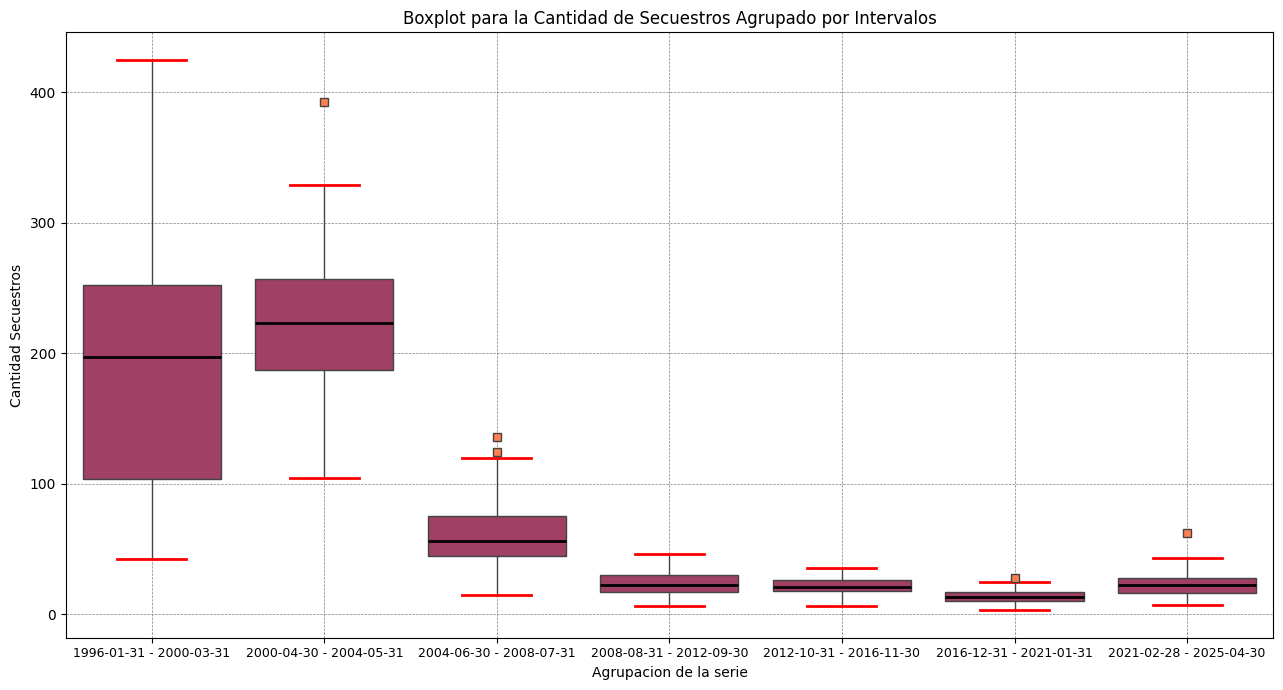

In [199]:
serie_colombia_mensual = serie_colombia_mensual.copy()  

serie_colombia_mensual.loc[:, 'AÑO'] = pd.to_datetime(serie_colombia_mensual['AÑO'])
serie_colombia_mensual.loc[:, 'grupo_fecha'] = pd.cut(serie_colombia_mensual['AÑO'], bins=7, labels=False)

grupo_limites = serie_colombia_mensual.groupby('grupo_fecha')['AÑO'].agg(['min', 'max']).reset_index()
plt.figure(figsize=(13, 7))
sns.boxplot(x='grupo_fecha', y='TOTAL', data=serie_colombia_mensual, color='#B03060' , capprops = dict(color = "red", linewidth = 2)
, flierprops = dict(marker = "s", markerfacecolor = '#FF7F50') , medianprops=dict(color='black', linewidth=2))
plt.xticks(ticks=range(len(grupo_limites)), labels=[f'{min_date.strftime("%Y-%m-%d")} - {max_date.strftime("%Y-%m-%d")}' for min_date, max_date in zip(grupo_limites['min'], grupo_limites['max'])])
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tick_params(axis='x', labelsize=9)
plt.xlabel('Agrupacion de la serie')
plt.ylabel('Cantidad Secuestros')
plt.title('Boxplot para la Cantidad de Secuestros Agrupado por Intervalos')
plt.tight_layout()
plt.show()

The grouped boxplot over chronological intervals clearly shows the dramatic reduction in kidnappings over time:

1. **1996–2000**  
   - High median (around 200 cases) and a very wide box, reflecting high dispersion and several outliers above 300–400 kidnappings.  
   - Indicates a period of maximum volatility and volume of kidnappings.

2. **2000–2004**  
   - Median rises even further (~220 cases), but dispersion begins to narrow slightly.  
   - Extreme values still appear, although less frequently.

3. **2004–2008**  
   - Median now near 50–60 cases, with a reduced interquartile range.  
   - Reflects the impact of paramilitary demobilization and Plan Colombia.

4. **2008–2012**  
   - Median falls to approximately 25 cases and the box compresses even more.  
   - Few outliers, suggesting a more stable series.

5. **2012–2016** and **2016–2021**  
   - Medians drop below 25 and then below 15 cases, with very low dispersion.  
   - Minimal internal variability indicates a residual and predictable kidnapping environment.

6. **2021–2025**  
   - Slight uptick in median (around 20–25) and minor outliers, suggesting emerging kidnapping hotspots.  
   - Still, values remain far below historical levels.

Overall, the boxplot demonstrates a transition from a phase of high frequency and volatility (1996–2004) to one of low incidence and stability (2008–2021), with a slight increase in the most recent years.  



### **3.1.2 Additive series decomposition**

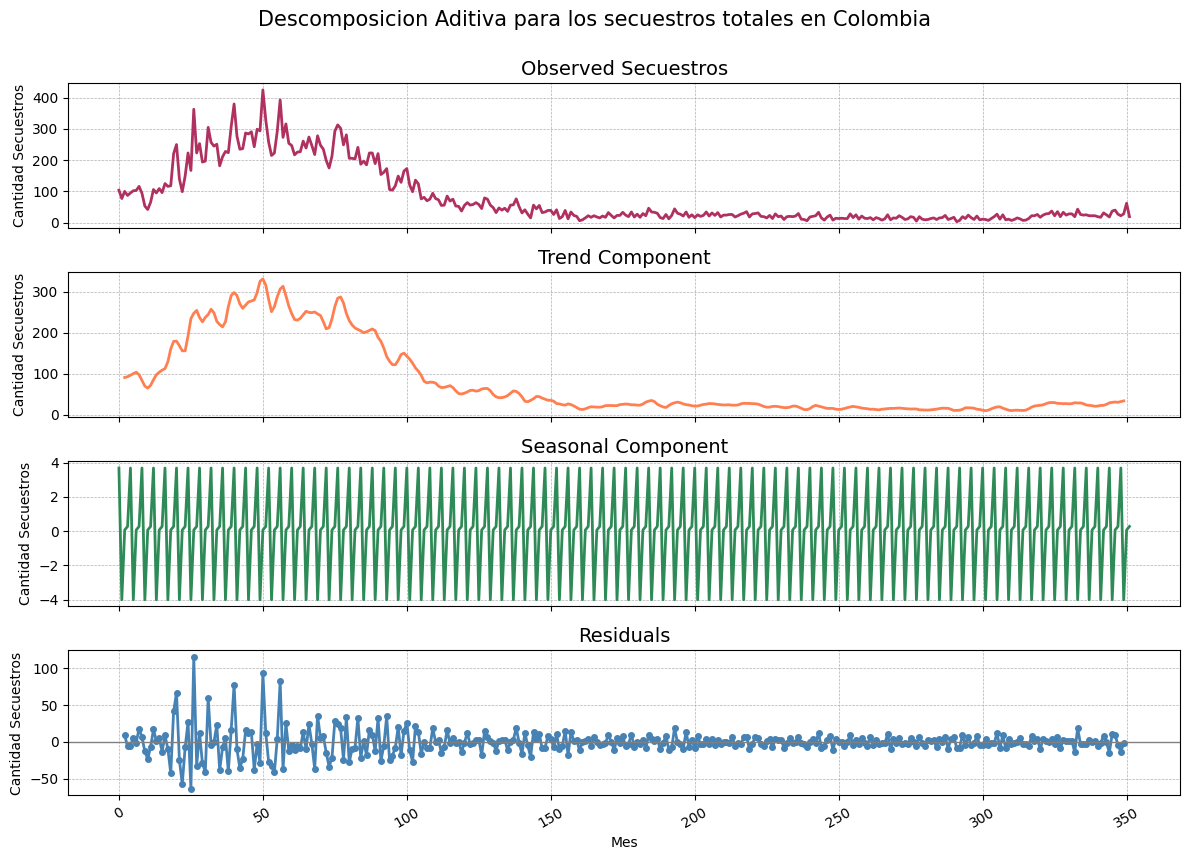

In [26]:
result = seasonal_decompose(serie_colombia_mensual['TOTAL'], model='additive',period=4)           

fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Descomposicion Aditiva para los secuestros totales en Colombia', fontsize=15, y=0.95)

axes[0].plot(serie_colombia_mensual.index, result.observed, color='#B03060', lw=2)
axes[0].set_title('Observed Secuestros', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)

axes[1].plot(serie_colombia_mensual.index, result.trend, color='#FF7F50', lw=2)
axes[1].set_title('Trend Component', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)

axes[2].plot(serie_colombia_mensual.index, result.seasonal, color='#2E8B57', lw=2)
axes[2].set_title('Seasonal Component', fontsize=14)
axes[2].grid(True, linestyle='--', linewidth=0.5)

axes[3].plot(serie_colombia_mensual.index, result.resid, color='#4682B4', lw=2, marker='o', ms=4)
axes[3].axhline(0, color='gray', lw=1)
axes[3].set_title('Residuals', fontsize=14)
axes[3].grid(True, linestyle='--', linewidth=0.5)

for ax in axes:
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_ylabel('Cantidad Secuestros')

axes[-1].set_xlabel('Mes')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Observed**  
The series reaches its peak in 1999–2000 with 300–400 monthly kidnappings, then declines rapidly from 2002 to levels below 50 cases per month. By 2025 it only shows a slight uptick.

**Trend**  
The trend component shows a sustained rise in the ’90s, followed by a pronounced drop between 2002 and 2006 that levels off from 2007 onward. This behavior reflects the impact of Plan Colombia and the demobilization processes.

**Seasonal**  
The decomposition reveals moderate annual oscillations (±3–4 kidnappings) that repeat consistently throughout the series. This indicates a stable influence of local cyclical factors on the crime.

**Residuals**  
Between 1996 and 2005 the residuals exhibit high dispersion, with abrupt peaks indicating episodes of sudden violence. From 2007 onward they cluster around zero, showing greater predictability after the signing of peace agreements and demobilizations.  





### 3.2 Descriptive statistics for monthly panels

In [6]:
def generar_tabla(df:pd.DataFrame , tipo:str , col:str) -> pd.DataFrame:
    """
    Genera un resumen estadístico de la columna 'TOTAL' y la mediana de 'N_SIMPLE' 
    y 'N_EXTORSIVO' agrupado por la columna especificada.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene, al menos, las columnas ['TOTAL', 'N_SIMPLE', 'N_EXTORSIVO']
        y la(s) columna(s) indicada(s) en el parámetro `tipo` para agrupar.
    tipo : str or list of str
        Nombre de la columna o lista de columnas por las cuales agrupar el DataFrame.
        Por ejemplo: 'DEPARTAMENTO'.
    col : Columna para la que se haran las estadisticas

    Retorna
    -------
    pandas.DataFrame
        DataFrame con un registro por cada nivel de agrupación, ordenado de mayor a menor
        según la media de 'TOTAL', y con las siguientes columnas:
        
        - tipo... : la(s) columna(s) de agrupación.
        - TOTAL_mean : media aritmética de la variable 'TOTAL'.
        - TOTAL_q25 : primer cuartil (25%) de 'TOTAL'.
        - TOTAL_median : mediana (50%) de 'TOTAL'.
        - TOTAL_q75 : tercer cuartil (75%) de 'TOTAL'.
        - TOTAL_mode : moda de 'TOTAL' (primer valor en caso de múltiples).
        - TOTAL_min : valor mínimo de 'TOTAL'.
        - TOTAL_max : valor máximo de 'TOTAL'.
        - TOTAL_std : desviación estándar de 'TOTAL'.
        - N_SIMPLE_median : mediana de 'N_SIMPLE'.
        - N_EXTORSIVO_median : mediana de 'N_EXTORSIVO'.
    """

    df1 = df.groupby(tipo).agg(
        TOTAL_mean=(col, 'mean'),
        TOTAL_q25 = (col,  lambda x: x.quantile(0.25)),
        TOTAL_median=(col, 'median'),
        TOTAL_q75  = (col,  lambda x: x.quantile(0.75)),
        TOTAL_mode= (col,  lambda x: x.mode().iat[0] if not x.mode().empty else np.nan),
        TOTAL_min= (col,  'min'),
        TOTAL_max= (col,  'max'),
        TOTAL_std=(col, 'std'),
        N_SIMPLE_median=('N_SIMPLE', 'median'),
        N_EXTORSIVO_median=('N_EXTORSIVO', 'median')).reset_index().sort_values('TOTAL_mean', ascending=False)
    
    return df1



In [7]:

estadisticos_mensuales_dept = generar_tabla(departamentos_mensual , 'DEPARTAMENTO' , 'TOTAL')
estadisticos_mensuales_dept.head(15)


,DEPARTAMENTO,TOTAL_mean,TOTAL_q25,TOTAL_median,TOTAL_q75,TOTAL_mode,TOTAL_min,TOTAL_max,TOTAL_std,N_SIMPLE_median,N_EXTORSIVO_median
1,ANTIOQUIA,14.980892,2.00,4.5,24.75,2,1,90,19.649638,1.0,3.0
31,VAUPES,10.375000,1.00,1.0,3.50,1,1,68,23.409018,0.5,0.5
11,CESAR,9.833333,1.00,3.0,15.00,1,1,71,13.338526,1.0,2.0
27,SANTANDER,8.247191,2.00,5.0,11.00,1,1,70,9.623748,1.0,3.0
5,BOLIVAR,6.784314,1.00,4.0,8.00,1,1,80,9.190915,1.0,3.0
14,CUNDINAMARCA,6.390476,1.00,3.0,9.00,1,1,42,7.719354,1.0,2.0
30,VALLE DEL CAUCA,6.214511,2.00,4.0,7.00,1,1,167,11.207679,1.0,3.0
19,MAGDALENA,5.924855,1.00,3.0,9.00,1,1,35,6.442060,1.0,2.0
20,META,5.846809,1.00,3.0,8.00,1,1,41,6.019372,1.0,2.0
29,TOLIMA,5.533654,1.75,4.0,7.25,1,1,33,5.503519,1.0,2.0


This summary presents the fifteen departments with the highest monthly average of kidnappings during the 1996–2005 period, led by Antioquia with nearly 15 cases per month—more than double that of Cesar in third place (9.8). The interquartile range shows that, while 25% of months record between one and two incidents in most regions, 75% reach values between 7 and almost 25 in Antioquia, highlighting episodes of acute escalation. Medians hover around 4–5 cases, suggesting that kidnappings remain a persistent issue year after year. However, extraordinary peaks—such as the maximum of 167 cases in Valle del Cauca—indicate atypical months of violence that inflate the statistics. The standard deviation, highest in departments with pronounced contrasts, confirms the temporal irregularity of incidents. Finally, the comparison between the median of simple and extortive kidnappings (between 1 and 3) shows that although extortive kidnappings predominate, in certain areas simple kidnappings carry significant weight.  




In [15]:
estadisticos_mensuales_mun = generar_tabla(municipios_mensual , 'MUNICIPIO', 'TOTAL')
estadisticos_mensuales_mun.head(15)

,MUNICIPIO,TOTAL_mean,TOTAL_q25,TOTAL_median,TOTAL_q75,TOTAL_mode,TOTAL_min,TOTAL_max,TOTAL_std,N_SIMPLE_median,N_EXTORSIVO_median
472,MITU,12.333333,1.00,1.0,1.75,1,1,68,27.273919,0.5,0.5
469,MIRAFLORES,10.375000,1.00,1.0,1.00,1,1,76,26.516504,0.5,0.5
93,BOJAYA,8.000000,8.00,8.0,8.00,8,8,8,NaN,8.0,0.0
415,LEIVA,7.833333,1.00,1.0,1.75,1,1,41,16.253205,0.0,1.0
138,CARMEN DE CARUPA,7.000000,7.00,7.0,7.00,7,7,7,NaN,0.0,7.0
691,SAN JUAN DE URABA,6.000000,1.00,1.0,8.50,1,1,16,8.660254,0.0,1.0
506,NOROSI,6.000000,6.00,6.0,6.00,6,6,6,NaN,0.0,6.0
229,DISTRACCION,5.666667,1.50,2.0,8.00,1,1,14,7.234178,0.0,2.0
158,CHAMEZA,5.500000,3.25,5.5,7.75,1,1,10,6.363961,4.5,1.0
808,TENA,5.500000,3.25,5.5,7.75,1,1,10,6.363961,4.5,1.0


In the municipal analysis, Mitú leads with an average of 12.3 kidnappings per month between 1996 and 2005, followed by Miraflores (10.4) and Bojayá (8.0), the latter showing a perfectly uniform distribution (median and mode at 8, indicating a single data point). While 25% of months in most localities record only one incident, 75% in Carmen de Carupa reach seven cases, and in San Juan de Urabá rise to 8.5, denoting localized spikes of violence. Variability is especially high in Mitú and Miraflores (standard deviations above 26), suggesting months of relative calm interspersed with acute outbreaks. In Leiva, although the mean is lower (7.8), the standard deviation of 16.2 indicates notable fluctuations. Comparing medians of simple versus extortive kidnappings, Bojayá and Norosí stand out where all incidents were simple, whereas Carmen de Carupa recorded seven extortive cases—an indication of mixed-pressure tactics. In municipalities like Chámeza and Tena, the median of simple kidnappings (4.5) doubles that of extortive ones (1), highlighting the predominance of pure kidnappings in these areas.  



### 3.3 Estadisticos descriptivos para los paneles anuales

In [16]:
estadisticos_anual_dept = generar_tabla(departamentos_anual , 'DEPARTAMENTO' , 'TOTAL')
estadisticos_anual_dept.head(15)

,DEPARTAMENTO,TOTAL_mean,TOTAL_q25,TOTAL_median,TOTAL_q75,TOTAL_mode,TOTAL_min,TOTAL_max,TOTAL_std,N_SIMPLE_median,N_EXTORSIVO_median
1,ANTIOQUIA,156.800000,26.00,38.0,262.50,26,12,681,213.305092,14.5,24.0
11,CESAR,70.800000,6.00,9.5,80.00,3,1,398,115.495753,3.0,7.0
30,VALLE DEL CAUCA,65.666667,24.75,36.5,68.75,27,11,329,74.173763,11.5,25.0
4,BOGOTA D.C.,51.800000,15.00,29.5,61.25,13,9,186,52.450568,10.5,16.0
27,SANTANDER,50.620690,3.00,8.0,56.00,2,1,306,81.047347,2.0,4.0
20,META,47.379310,9.00,16.0,85.00,5,2,165,51.842766,7.0,10.0
22,NORTE DE SANTANDER,45.600000,20.00,26.0,46.75,23,5,207,50.233661,11.0,15.5
14,CUNDINAMARCA,44.733333,5.25,9.5,42.00,5,1,223,66.337659,2.0,6.5
5,BOLIVAR,39.923077,3.00,7.0,47.50,2,1,249,60.549433,3.5,4.0
29,TOLIMA,38.366667,3.00,11.0,71.50,2,1,145,45.152984,2.5,10.5


When comparing the annual version with the monthly, a clear consistency in the ranking emerges: Antioquia, Cesar, Valle del Cauca, and Bogotá D.C. maintain their leadership both in monthly averages (≈15, 9.8, 6.2, and 5.5 cases) and in annual totals (≈157, 71, 66, and 52 kidnappings). In the annual table, the 25th percentile ranges between 1 and 26 kidnappings per year, while each department’s median spans from 8 up to 38 cases, with a 75th percentile reaching 262.5 in Antioquia—concentrating most incidents in particularly violent years. The standard deviations, starting at around 21 in Nariño and exceeding 213 in Antioquia, highlight the alternation of relatively calm periods with acute kidnapping spikes. Finally, the annual median of simple kidnappings fluctuates between 2 and 16.5 cases, and that of extortive kidnappings between 1 and 24, underscoring how both modalities have coexisted with varying intensity over the years.  



In [17]:
estadisticos_anual_mun = generar_tabla(municipios_anual , 'MUNICIPIO' , 'TOTAL')
estadisticos_anual_mun.head(15)

,MUNICIPIO,TOTAL_mean,TOTAL_q25,TOTAL_median,TOTAL_q75,TOTAL_mode,TOTAL_min,TOTAL_max,TOTAL_std,N_SIMPLE_median,N_EXTORSIVO_median
91,BOGOTA D.C.,51.800000,15.00,29.5,61.25,13,9,186,52.450568,10.5,16.0
121,CALI,33.200000,10.25,14.5,27.00,6,4,227,47.596291,5.0,9.5
460,MEDELLIN,29.666667,6.25,10.5,43.50,5,5,119,35.415108,4.0,6.5
860,VALLEDUPAR,27.315789,2.00,3.0,42.00,1,1,117,38.855934,1.0,3.0
885,VILLAVICENCIO,20.730769,2.25,6.0,37.75,2,1,77,23.425726,1.5,4.0
98,BUCARAMANGA,18.736842,2.00,12.0,29.00,1,1,80,22.452028,2.0,5.0
729,SANTA MARTA,16.608696,2.00,9.0,22.00,1,1,89,21.712458,3.0,3.0
180,CIENAGA,15.833333,1.00,4.0,21.25,1,1,62,22.263793,1.0,3.0
696,SAN LUIS,15.769231,1.00,5.0,12.00,1,1,69,22.391047,1.0,5.0
12,AGUSTIN CODAZZI,14.666667,2.00,9.0,14.00,1,1,92,25.010301,1.5,4.0


In the annual breakdown by municipality, Bogotá D.C. leads the list with an average of 51.8 kidnappings per year, followed by Cali (33.2) and Medellín (29.7), while smaller municipalities like Fundación and Mitú hover around 12 annual cases. The 25th percentile ranges between 1 and 15 kidnappings, and the median between 3 and nearly 30 in Bogotá, indicating that half of the years each locality endures at least that many incidents. The 75th percentile reaches 61.25 in Bogotá and exceeds 43 in Medellín, reflecting particularly critical years for those cities. The highest standard deviations in Bogotá (≈52) and Cali (≈48) emphasize the alternation between calm years and years of violence spikes, whereas in Cocorná, with a SD of 11, the variations are more moderate.  



### 3.4 Graficos de barra por departamentos 

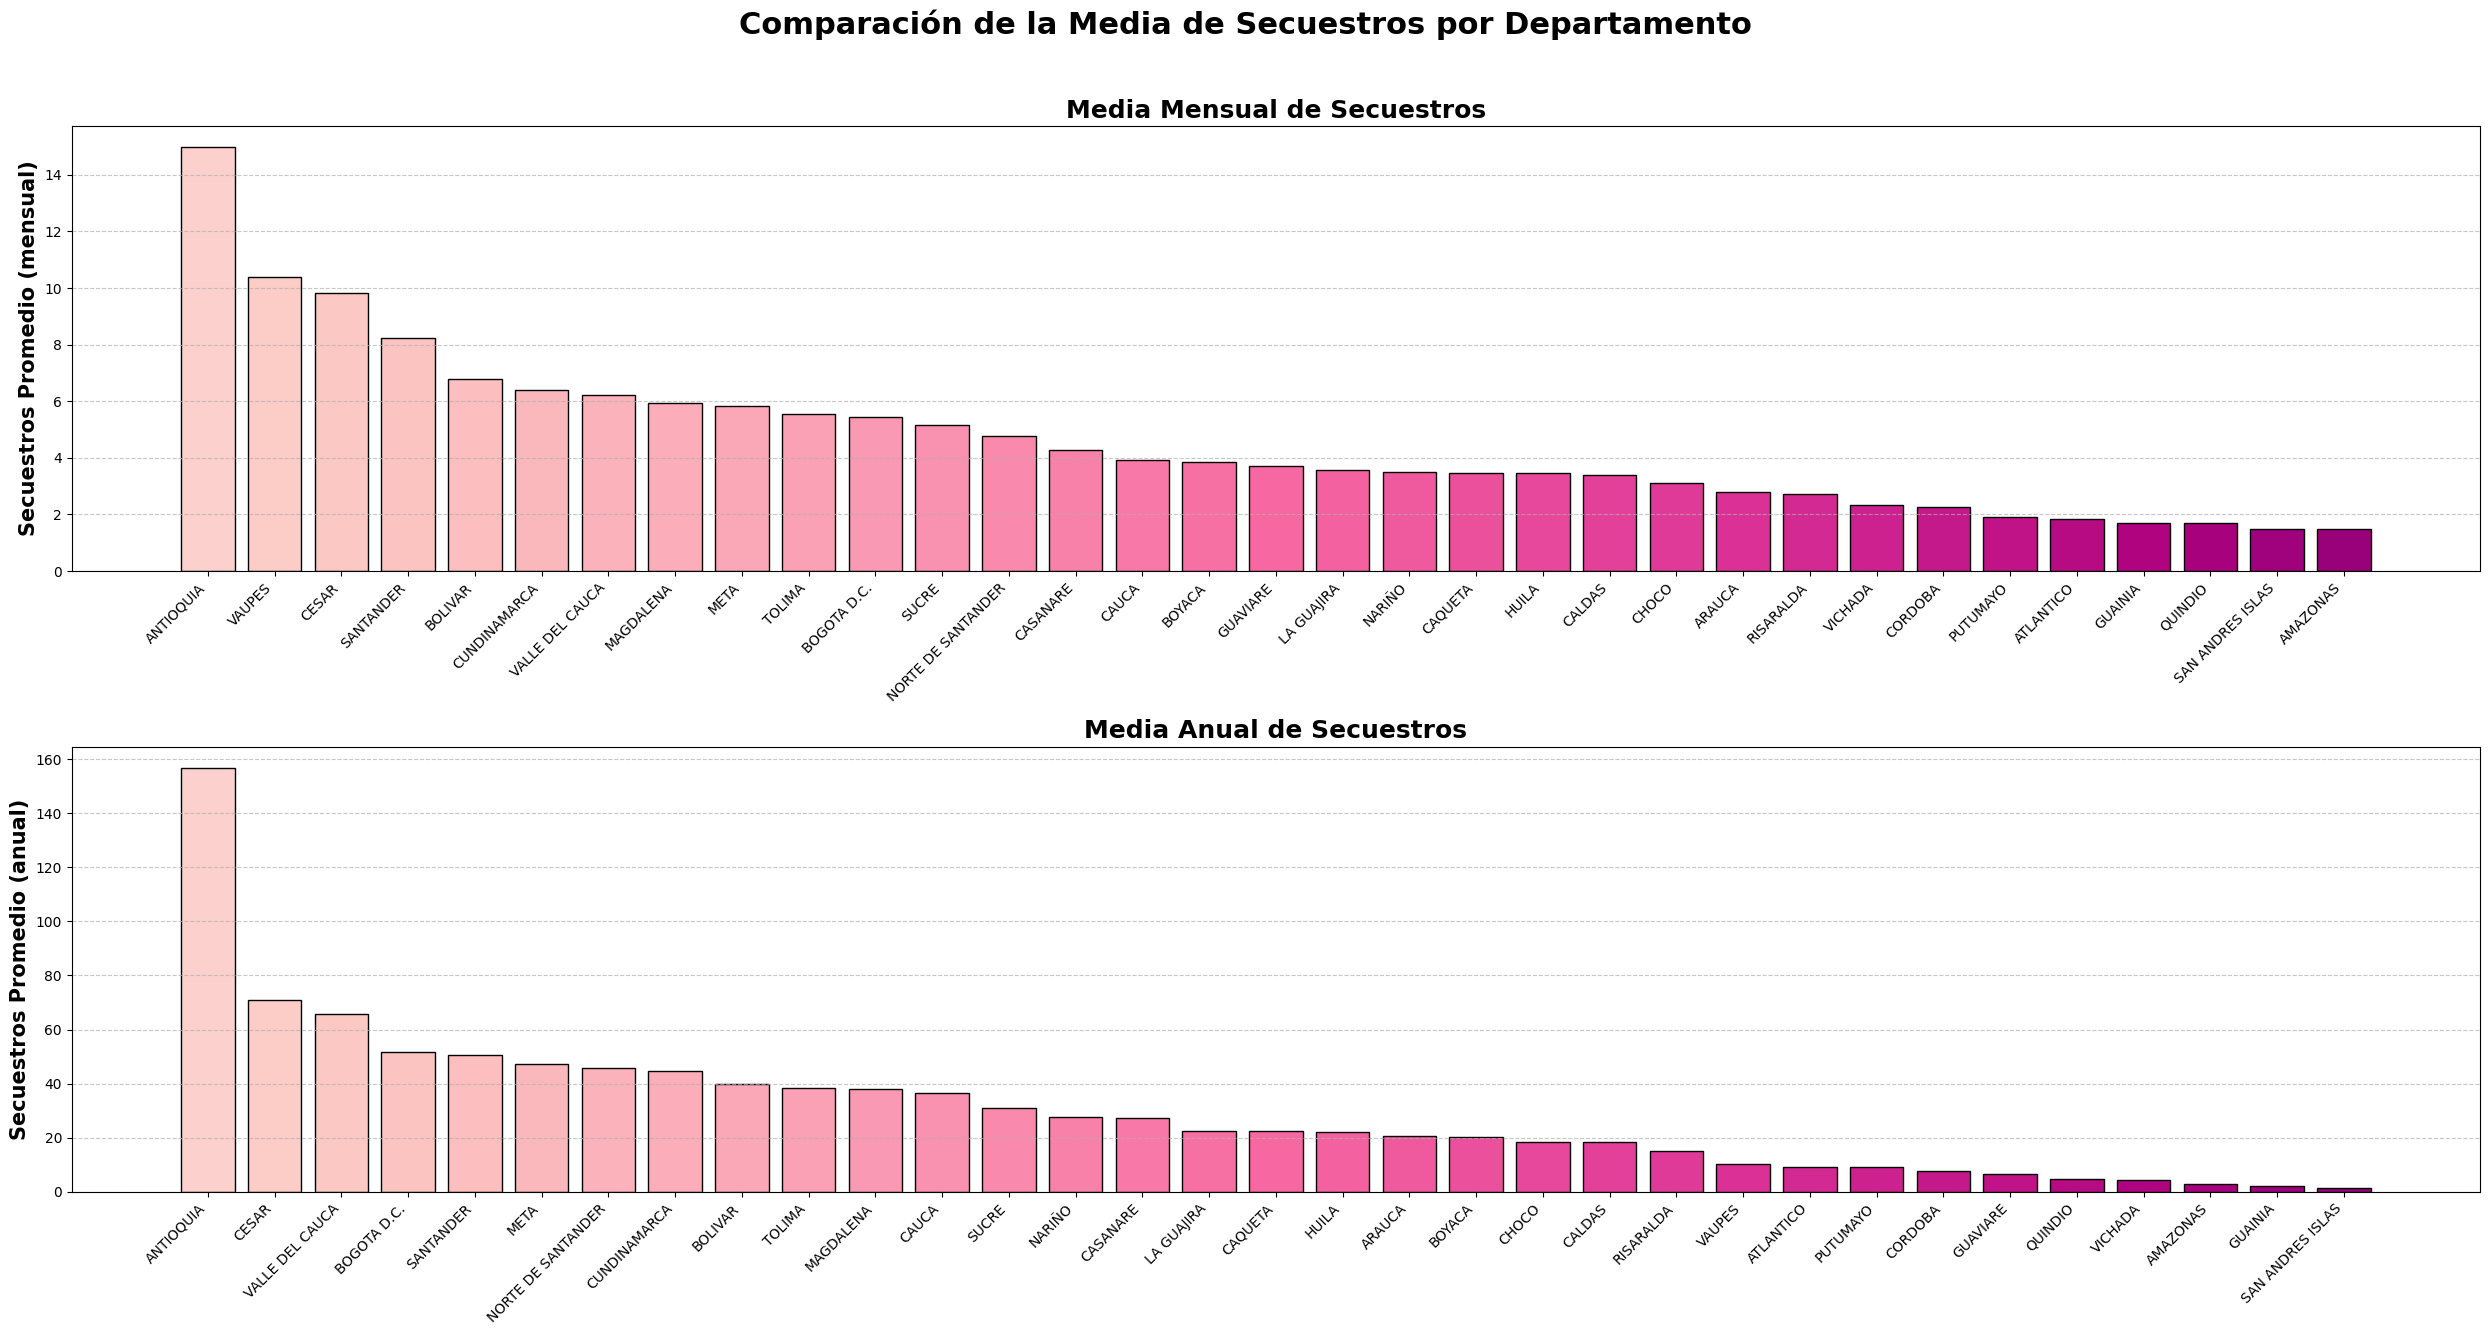

In [18]:

fig, axes = plt.subplots(2, 1, figsize=(25, 14), sharex=False)
fig.suptitle('Comparación de la Media de Secuestros por Departamento',fontsize=22, fontweight='bold', y=0.95)

cmap = plt.cm.RdPu  

x_mensual = np.arange(len(estadisticos_mensuales_dept))
colors_mensual = cmap(np.linspace(0.2, 0.8, len(x_mensual)))
bars1 = axes[0].bar(
    x_mensual,
    estadisticos_mensuales_dept['TOTAL_mean'],
    color=colors_mensual,
    edgecolor='black')
axes[0].set_title('Media Mensual de Secuestros', fontsize=18, fontweight='bold')
axes[0].set_ylabel('Secuestros Promedio (mensual)', fontsize=15, fontweight='bold')
axes[0].set_xticks(x_mensual)
axes[0].set_xticklabels(estadisticos_mensuales_dept['DEPARTAMENTO'], rotation=45, ha='right', fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

x_anual = np.arange(len(estadisticos_anual_dept))
colors_anual = cmap(np.linspace(0.2, 0.8, len(x_anual)))
bars2 = axes[1].bar(
    x_anual,
    estadisticos_anual_dept['TOTAL_mean'],
    color=colors_anual,
    edgecolor='black')

axes[1].set_title('Media Anual de Secuestros', fontsize=18, fontweight='bold')
axes[1].set_ylabel('Secuestros Promedio (anual)', fontsize=15, fontweight='bold')
axes[1].set_xticks(x_anual)
axes[1].set_xticklabels(estadisticos_anual_dept['DEPARTAMENTO'], rotation=45, ha='right', fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

This graph visually illustrates the comparison of the monthly and annual averages of kidnappings by department, reproducing exactly the values ​​and order we already analyzed in the table.


### 3.5 Histograms and time series disaggregated by Department and Municipality

#### First we must define the functions that we will use to create the histogram and the ipywidgtes box

In [8]:

def histograma(var:pd.Series, name:str, ax , periodo:str):
    """
    Dibuja un histograma de una variable numérica en el eje dado, resaltando media y mediana.

    Esta función traza la distribución de frecuencia de `var` sobre `ax`, coloreando
    alternativamente las barras con dos tonos, y añade líneas verticales punteada y
    sólida para indicar la media y la mediana, respectivamente.

    Parámetros
    ----------
    var : pandas.Series o array-like
        Serie numérica con los datos a graficar (por ejemplo, número de secuestros mensuales).
    name : str
        Título o etiqueta descriptiva de la variable que aparecerá en la parte superior del histograma.
    ax : matplotlib.axes.Axes
        Objeto Axes de Matplotlib donde se dibujará el histograma.

    Retorna
    -------
    matplotlib.axes.Axes
        El mismo objeto `ax`, con el histograma ya dibujado y personalizado.
    """
    
    media = var.mean()
    mediana = var.median()
    colors = ['#B03060', '#FF7F50']

    n, bins, patches = ax.hist(var, bins='auto', alpha=0.7, edgecolor='black')
    for i, patch in enumerate(patches):
        patch.set_facecolor(colors[i % len(colors)])

    ax.axvline(x=media, color='green', linestyle='dashed', linewidth=1.5, label=f'Media={media:.1f}')
    ax.axvline(x=mediana, color='black', linestyle='-', linewidth=1.5, label=f'Mediana={mediana:.1f}')
    ax.legend(fontsize=10)
    ax.set_title('Histograma ' + name+ periodo, fontsize=12, weight='bold')
    ax.tick_params(axis='both', labelsize=6)
    ax.set_xlabel('Secuestros', fontsize=10)
    ax.set_ylabel('Freq.', fontsize=10)
    return ax

def plot_mun(change:dict , df:pd.DataFrame , col:str , fechas:str , variable:str , output:widgets.Output) -> widgets.Output :
    """
    ibuja en un widget interactivo un histograma, una serie temporal con media movil y varianza movil para el 
    municipio o departamento seleccionado en la periodicidad seleccionada.

    Este callback está pensado para usarse con un `Dropdown` de ipywidgets cuyo 
    cambio dispara la función, refrescando dos gráficos lado a lado:
      1. Histograma de la distribución de la variable (e.g., número de secuestros).
      2. Serie temporal de esa variable a lo largo de la columna de fechas.

    Parámetros
    ----------
    change : dict
        Diccionario que provee el widget al dispararse el evento; debe contener
        la clave 'new' con el valor del municipio seleccionado.
    df : pandas.DataFrame
        DataFrame con los datos originales. Debe incluir las columnas nombradas
        en `col`, `fechas` y `variable`.
    col : str
        Nombre de la columna en `df` que identifica el municipio (o categoría) a filtrar.
    fechas : str
        Nombre de la columna de tipo datetime en `df` que contiene la fecha de cada registro.
    variable : str
        Nombre de la columna numérica en `df` cuyos valores se grafican (por ejemplo, 'TOTAL').
    output : ipywidgets.Output
        Contenedor de salida donde se borrará y volverá a dibujar la figura.

    Comportamiento
    -------------
    1. Limpia el contenido anterior de `output`.  
    2. Crea una figura con dos ejes (histograma a la izquierda, serie temporal a la derecha).  
    3. Filtra `df` para el municipio `change['new']`.  
    4. Genera el histograma con la función `histograma()`.  
    5. Traza la serie temporal en rojo, añade una línea horizontal punteada en la media anual  
       y activa una cuadrícula ligera.  
    6. Ajusta espacios y muestra todo dentro de `output`.

    """
    if fechas == 'MES':
        periodo = ' Mensual' 
        window = 5
    else:
        periodo = ' Anual' 
        window = 2

    with output:
        output.clear_output(wait=True)

        fig, axes = plt.subplots(ncols=3, figsize=(20, 5), dpi=100, gridspec_kw={'width_ratios': [1, 1, 0.8]})

        # Histograma 
        data = df.loc[df[col] == change['new'], variable]
        # Usamos la funcion que creamos 
        histograma(data, change['new'], ax=axes[0], periodo=periodo)

        # Serie base y media movil 
        serie = (df.loc[df[col] == change['new'], [fechas, variable]].sort_values(fechas).set_index(fechas))
        
        mean_ts = serie[variable].mean()
        serie['rolling_mean'] = serie[variable].rolling(window).mean()
        ax_rm = axes[1]
        ax_rm.plot(serie.index, serie[variable],
                color='#B03060', alpha=0.6, lw=1, label='Raw')
        ax_rm.plot(serie.index, serie['rolling_mean'],
                color='darkorange', ls='--', lw=3, label=f'{window}-wan Media Movil')
        
        ax_rm.axhline(mean_ts,color='green',linestyle='--',lw=1.5,label=f'Media={mean_ts:.1f}')
        
        ax_rm.set_title(f'Raw + Media Movil en {change["new"] + periodo}', fontsize=12, weight='bold')
        ax_rm.set_xlabel('Fecha'); ax_rm.set_ylabel(variable)
        ax_rm.tick_params(labelrotation=45, labelsize=8)
        ax_rm.legend(fontsize=9)
        ax_rm.grid(True, linestyle='--', alpha=0.3)

        # Varianza movil de la serie 
        serie['rolling_var'] = serie[variable].rolling(window).var()
        ax_var = axes[2]
        ax_var.fill_between(serie.index, serie['rolling_var'], color='navy', alpha=0.4,
                            label=f'{window}-wan Varianza Movil')
        ax_var.plot(serie.index, serie['rolling_var'], color='navy', lw=2)
        ax_var.set_title(f'Varianza Movil en {change["new"] + periodo}', fontsize=12, weight='bold')
        ax_var.set_xlabel('Fecha'); ax_var.set_ylabel('Varianza')
        ax_var.tick_params(labelrotation=45, labelsize=8)
        ax_var.legend(fontsize=9)
        ax_var.grid(True, linestyle='--', alpha=0.3)


        plt.tight_layout()
        plt.show()


### Dado que la funciones creadas arriba estan parametrizadas, es facil hacer un analisis tanto mensual como anual de los histogramas y series de tiempo para cada departamento y municipio

#### **Widget para los Departamentos en la serie mensual**

In [ ]:

municipios = sorted(departamentos_mensual['DEPARTAMENTO'].unique())
dropdown = widgets.Dropdown(options=municipios, description='Departamento:', layout=widgets.Layout(width='50%'))
output = widgets.Output() 
callback = partial(plot_mun, df=departamentos_mensual ,col='DEPARTAMENTO' ,fechas='MES' ,variable='TOTAL' , output= output)

dropdown.observe(callback, names='value')
display(dropdown, output)
callback({'new': municipios[0]})



![alt text](../Showcase_Widegts/Widget_Deaprtamentos_mensualmente.png)


<mark> Important: Github does not directly support loading Interactive Widgets, so we consider the images of how they would look if you run the code. <mark>

#### **Widget para los Municipios en la serie mensual**

In [ ]:
municipios = sorted(municipios_mensual['MUNICIPIO'].unique())
dropdown = widgets.Dropdown(options=municipios, description='Municipio:', layout=widgets.Layout(width='50%'))
output = widgets.Output()


callback = partial(plot_mun, df=municipios_mensual ,col='MUNICIPIO' ,fechas='MES' ,variable='TOTAL' , output= output)

dropdown.observe(callback, names='value')
display(dropdown, output)
callback({'new': municipios[0]})

![alt text](../Showcase_Widegts/Municipios_Mensual.png)

## To view the annual charts, it's as easy as:

#### **Widget for Departments in the annual series**

In [ ]:

municipios = sorted(departamentos_anual['DEPARTAMENTO'].unique()) # Cambiar la base de datos 
dropdown = widgets.Dropdown(options=municipios, description='Departamento:', layout=widgets.Layout(width='50%'))
output = widgets.Output() 
callback = partial(plot_mun, df=departamentos_anual ,col='DEPARTAMENTO' ,fechas='AÑO' ,variable='TOTAL' , output= output) # Cambiar la base y el nombre de las fechas

dropdown.observe(callback, names='value')
display(dropdown, output)
callback({'new': municipios[0]})

![alt text](../Showcase_Widegts/Departamentos_anual.png)

#### **Widget for Municipalities in the annual series**

In [ ]:
municipios = sorted(municipios_anual['MUNICIPIO'].unique()) # Cambiar la base de datos 
dropdown = widgets.Dropdown(options=municipios, description='Municipio:', layout=widgets.Layout(width='50%'))
output = widgets.Output() 
callback = partial(plot_mun, df=municipios_anual ,col='MUNICIPIO' ,fechas='AÑO' ,variable='TOTAL' , output= output) # Cambiar la base y el nombre de las fechas

dropdown.observe(callback, names='value')
display(dropdown, output)
callback({'new': municipios[0]})

![alt text](../Showcase_Widegts/Municipios_Anuales.png)

****
# **4. Geospatial Analysis**
****

### We load the database with geometry of the departments and municipalities

In [156]:
gdf_dept = gpd.read_file('../Datos/Colombia.json')
gdf_muni = gpd.read_file('../Datos/Colombia_municipios.geojson')
gdf_dept.head(5)

,DPTO,NOMBRE_DPT,AREA,PERIMETER,HECTARES,geometry
0,05,ANTIOQUIA,6.335186e+10,1963728.843,6335185.555,"POLYGON ((-76.3073 8.6193, -76.2981 8.6164, -7..."
1,08,ATLANTICO,3.360765e+09,240936.172,336076.535,"POLYGON ((-74.8706 10.3612, -74.8764 10.3433, ..."
2,11,SANTAFE DE BOGOTA D.C,1.650948e+09,323322.540,165094.778,"POLYGON ((-74.0229 4.7951, -74.0264 4.7836, -7..."
3,13,BOLIVAR,2.614189e+10,1309427.968,2614189.453,"POLYGON ((-75.1595 10.4236, -75.1543 10.4097, ..."
4,15,BOYACA,2.335258e+10,1364539.911,2335258.246,"POLYGON ((-72.213 7.0275, -72.2061 7.0246, -72..."


In [147]:
gdf_muni.head(5)

,geo_point_2d,area,perimeter,dpto,nombre_dpt,mpio,nombre_mpi,nombre_cab,mpios,hectares,geometry
0,"{ ""lon"": -77.346268522351778, ""lat"": 7.3741591...",6.098643e+09,488610.332913,27,CHOCO,615,RIOSUCIO,RIOSUCIO,27615,609864.309,"POLYGON ((-77.2136 7.9005, -77.1825 7.8859, -7..."
1,"{ ""lon"": -75.234033472401208, ""lat"": 7.6666705...",2.035307e+09,215948.208880,05,ANTIOQUIA,120,CACERES,CACERES,05120,203530.737,"POLYGON ((-75.32752 7.92516, -75.3217 7.9318, ..."
2,"{ ""lon"": -75.013486896587466, ""lat"": 7.8428025...",1.320916e+09,192458.577308,05,ANTIOQUIA,154,CAUCASIA,CAUCASIA,05154,132091.590,"POLYGON ((-75.21455 8.03189, -75.2019 8.0318, ..."
3,"{ ""lon"": -76.57313264658346, ""lat"": 7.90405236...",5.748969e+08,117191.417353,05,ANTIOQUIA,045,APARTADO,APARTADO,05045,57489.692,"POLYGON ((-76.4067 8.0831, -76.413 8.0733, -76..."
4,"{ ""lon"": -72.523550224635272, ""lat"": 7.7554453...",1.088367e+08,65708.331744,54,NORTE DE SANTANDER,874,VILLA DEL ROSARIO,VILLA DEL ROSARIO,54874,10883.669,"POLYGON ((-72.5023 7.8715, -72.4919 7.868, -72..."


As we can see, both bases have the Geometry column with their respective polygons for Colombia.

### We group by departments

In [148]:
departamento_total_casos = departamentos_anual.groupby(['DEPARTAMENTO','COD_DEPTO'])[['N_SIMPLE' , 'N_EXTORSIVO' , 'TOTAL']].sum().reset_index()
gdf_dept['DPTO'] = gdf_dept['DPTO'].astype(int)
departamento_total_casos['DPTO'] = departamento_total_casos['COD_DEPTO'].astype(int)
departamento_total_casos.head(5)

,DEPARTAMENTO,COD_DEPTO,N_SIMPLE,N_EXTORSIVO,TOTAL,DPTO
0,AMAZONAS,91,0,3,3,91
1,ANTIOQUIA,5,1904,2800,4704,5
2,ARAUCA,81,336,284,620,81
3,ATLANTICO,8,80,167,247,8
4,BOGOTA D.C.,11,598,956,1554,11


### We join the df with the geo df

In [141]:
gdf_dept1 = gdf_dept.merge(departamento_total_casos[['DPTO', 'N_SIMPLE' ,'N_EXTORSIVO' , 'TOTAL']], on='DPTO' ,how='left' ,suffixes=('','_agg'))
gdf_dept1.head(10)

,DPTO,NOMBRE_DPT,AREA,PERIMETER,HECTARES,geometry,N_SIMPLE,N_EXTORSIVO,TOTAL
0,5,ANTIOQUIA,6.335186e+10,1963728.843,6335185.555,"POLYGON ((-76.3073 8.6193, -76.2981 8.6164, -7...",1904,2800,4704
1,8,ATLANTICO,3.360765e+09,240936.172,336076.535,"POLYGON ((-74.8706 10.3612, -74.8764 10.3433, ...",80,167,247
2,11,SANTAFE DE BOGOTA D.C,1.650948e+09,323322.540,165094.778,"POLYGON ((-74.0229 4.7951, -74.0264 4.7836, -7...",598,956,1554
3,13,BOLIVAR,2.614189e+10,1309427.968,2614189.453,"POLYGON ((-75.1595 10.4236, -75.1543 10.4097, ...",289,749,1038
4,15,BOYACA,2.335258e+10,1364539.911,2335258.246,"POLYGON ((-72.213 7.0275, -72.2061 7.0246, -72...",183,347,530
5,17,CALDAS,7.558200e+09,603282.457,755819.988,"POLYGON ((-74.695 5.7527, -74.6847 5.751, -74....",111,345,456
6,18,CAQUETA,9.018087e+10,1888506.901,9018086.883,"POLYGON ((-74.6926 2.4978, -74.6891 2.4793, -7...",149,476,625
7,19,CAUCA,2.974279e+10,1243388.952,2974278.730,"MULTIPOLYGON (((-78.21162 2.97511, -78.2489 2....",405,693,1098
8,20,CESAR,2.297310e+10,1080343.678,2297309.568,"POLYGON ((-73.28232 10.85625, -73.28062 10.838...",898,1226,2124
9,23,CORDOBA,2.505949e+10,814093.372,2505948.561,"POLYGON ((-75.8195 9.423, -75.8091 9.4195, -75...",92,96,188


### We group by municipalities

In [166]:
municipios_total_casos = municipios_anual.groupby(['MUNICIPIO','COD_DEPTO'])[['N_SIMPLE' , 'N_EXTORSIVO' , 'TOTAL']].sum().reset_index()
gdf_muni['MUNICIPIO'] = gdf_muni['nombre_mpi'].astype(str)
municipios_total_casos['MUNICIPIO'] = municipios_total_casos['MUNICIPIO'] .astype(str)
municipios_total_casos.head(5)


,MUNICIPIO,COD_DEPTO,N_SIMPLE,N_EXTORSIVO,TOTAL
0,ABEJORRAL,5,23,25,48
1,ABREGO,54,13,92,105
2,ABRIAQUI,5,2,20,22
3,ACACIAS,50,54,44,98
4,ACANDI,27,5,5,10


### We unite the DF with the geo df of the municipalities

In [183]:
gdf_muni1 = gdf_muni.merge(municipios_total_casos[['MUNICIPIO', 'N_SIMPLE' ,'N_EXTORSIVO' , 'TOTAL']], on='MUNICIPIO' ,how='left' ,suffixes=('','_agg')).drop(columns=['geo_point_2d',])
gdf_muni1[['N_SIMPLE' ,'N_EXTORSIVO' , 'TOTAL']] = gdf_muni1[['N_SIMPLE' ,'N_EXTORSIVO' , 'TOTAL']].fillna(0)
gdf_muni1.head(10)

,area,perimeter,dpto,nombre_dpt,mpio,nombre_mpi,nombre_cab,mpios,hectares,geometry,MUNICIPIO,N_SIMPLE,N_EXTORSIVO,TOTAL
0,6.098643e+09,488610.332913,27,CHOCO,615,RIOSUCIO,RIOSUCIO,27615,609864.309,"POLYGON ((-77.2136 7.9005, -77.1825 7.8859, -7...",RIOSUCIO,4.0,59.0,63.0
1,6.098643e+09,488610.332913,27,CHOCO,615,RIOSUCIO,RIOSUCIO,27615,609864.309,"POLYGON ((-77.2136 7.9005, -77.1825 7.8859, -7...",RIOSUCIO,2.0,21.0,23.0
2,2.035307e+09,215948.208880,05,ANTIOQUIA,120,CACERES,CACERES,05120,203530.737,"POLYGON ((-75.32752 7.92516, -75.3217 7.9318, ...",CACERES,9.0,5.0,14.0
3,1.320916e+09,192458.577308,05,ANTIOQUIA,154,CAUCASIA,CAUCASIA,05154,132091.590,"POLYGON ((-75.21455 8.03189, -75.2019 8.0318, ...",CAUCASIA,8.0,12.0,20.0
4,5.748969e+08,117191.417353,05,ANTIOQUIA,45,APARTADO,APARTADO,05045,57489.692,"POLYGON ((-76.4067 8.0831, -76.413 8.0733, -76...",APARTADO,5.0,26.0,31.0
5,1.088367e+08,65708.331744,54,NORTE DE SANTANDER,874,VILLA DEL ROSARIO,VILLA DEL ROSARIO,54874,10883.669,"POLYGON ((-72.5023 7.8715, -72.4919 7.868, -72...",VILLA DEL ROSARIO,14.0,29.0,43.0
6,1.530013e+09,210190.675764,54,NORTE DE SANTANDER,3,ABREGO,ABREGO,54003,153001.287,"POLYGON ((-73.0905 8.2633, -73.072 8.2621, -73...",ABREGO,13.0,92.0,105.0
7,9.374662e+08,144732.546423,27,CHOCO,6,ACANDI,ACANDI,27006,93746.624,"POLYGON ((-77.10143 8.35414, -77.1142 8.3523, ...",ACANDI,5.0,5.0,10.0
8,4.915762e+08,115760.471841,05,ANTIOQUIA,495,NECHI,NECHI,05495,49157.618,"POLYGON ((-74.83394 8.18533, -74.8198 8.1793, ...",NECHI,4.0,15.0,19.0
9,3.570182e+08,81028.486149,54,NORTE DE SANTANDER,344,HACARI,HACARI,54344,35701.822,"POLYGON ((-72.99706 8.40527, -73.0006 8.4021, ...",HACARI,3.0,14.0,17.0


## We graph the total number of kidnappings by municipalities and departments

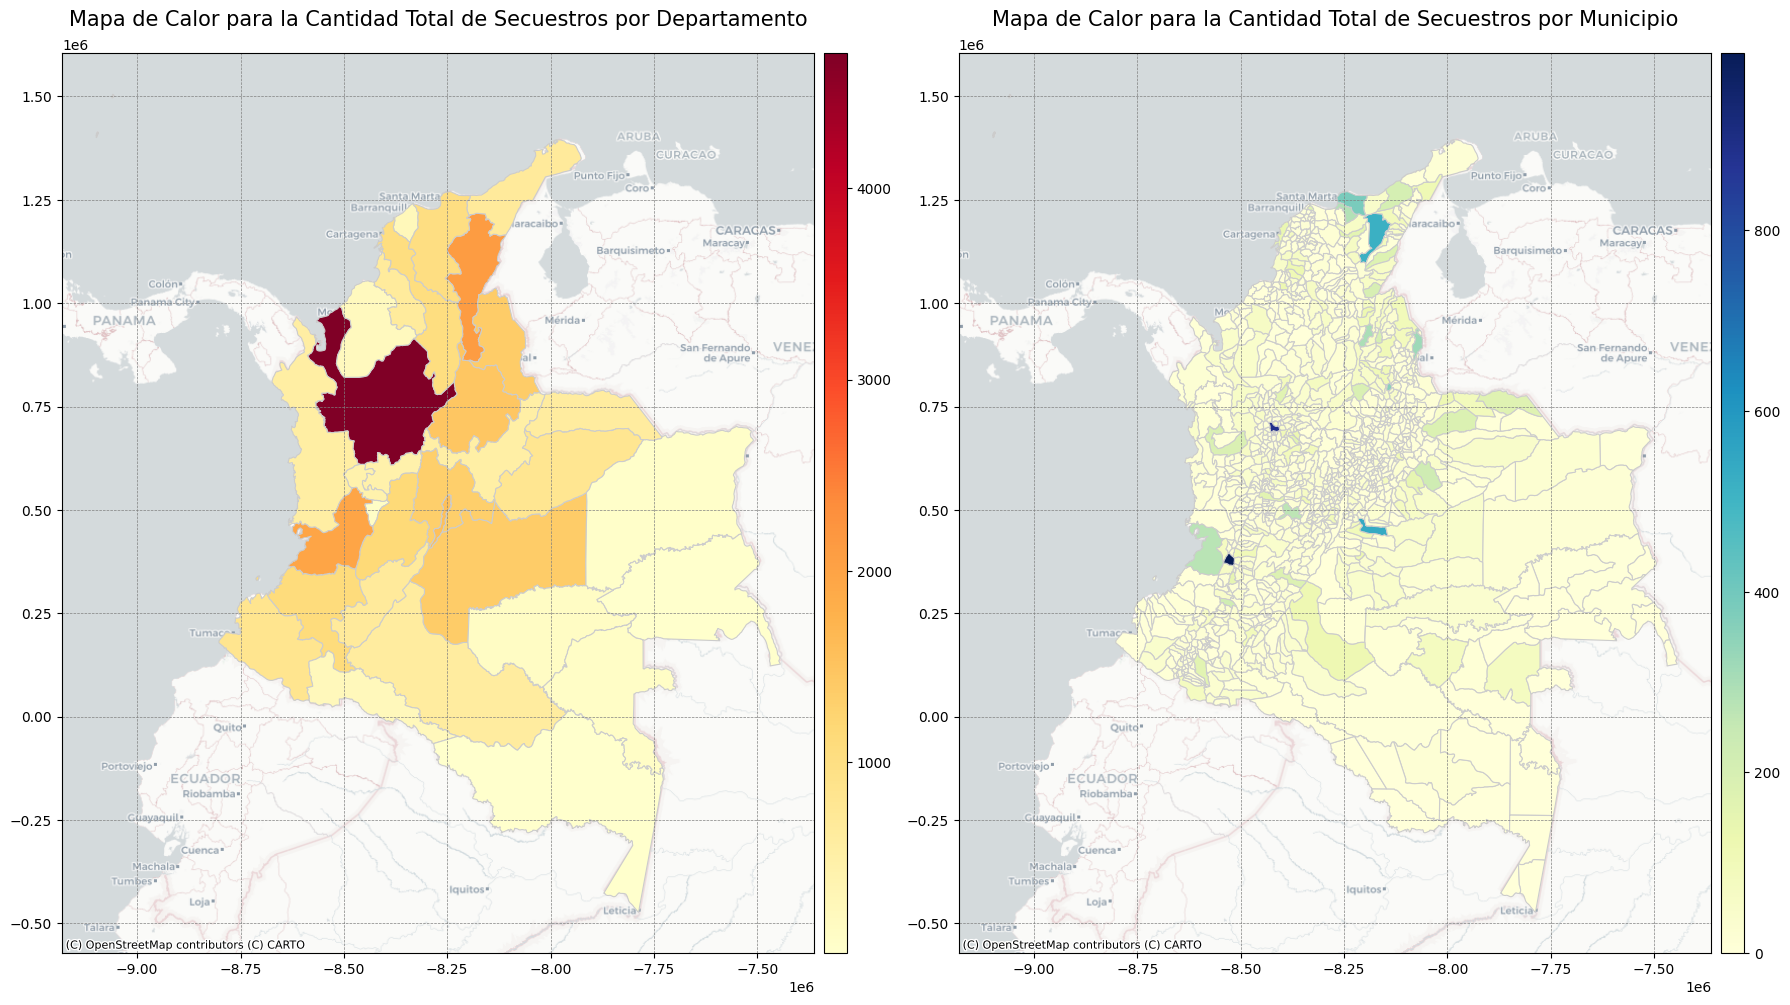

In [194]:

gdf_dept1 = gdf_dept1.to_crs(epsg=3857)
gdf_muni1 = gdf_muni1.to_crs(epsg=3857)

def mapa_secuestros_tipo(df:gpd.GeoDataFrame , df1:gpd.GeoDataFrame , tipo:str):
    """
    Genera dos mapas de calor consecutivos: uno a nivel de departamento y otro a nivel de municipio,
    coloreando según la columna de tipo de secuestro seleccionada.

    Parámetros
    ----------
    df : geopandas.GeoDataFrame
        GeoDataFrame con geometrías por departamento. Debe contener la columna `tipo` para colorear.
    df1 : geopandas.GeoDataFrame
        GeoDataFrame con geometrías por municipio. Debe contener la misma columna `tipo` que `df`.
    tipo : str
        Nombre de la columna a mapear. Valores válidos:
          - 'TOTAL'       : Cantidad total de secuestros.
          - 'N_EXTORSIVO' : Cantidad de secuestros extorsivos.
          - 'N_SIMPLE'    : Cantidad de secuestros simples.

    Comportamiento
    -------------
    1. Comprueba que `tipo` sea una de las columnas válidas; si no, retorna un mensaje de error.  
    2. Crea una figura con dos subplots horizontales.  
    3. En el primer eje (ax1), dibuja `df` usando la paleta 'YlOrRd', añade basemap, cuadrícula y leyenda.  
    4. En el segundo eje (ax2), dibuja `df1` con la paleta 'YlGnBu', añade basemap, cuadrícula y leyenda.  
    5. Ajusta automáticamente el layout para optimizar espacios.
    """
    
    if tipo == 'TOTAL':
        texto = ' la Cantidad Total de Secuestros '
    elif tipo == 'N_EXTORSIVO':
        texto = ' la Cantidad de Secuestros Extorsivos '
    elif tipo == 'N_SIMPLE':
        texto = ' la Cantidad de Secuestros Simples '
    else:
        return f'Ingrese una columna valida'

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="3%", pad=0.1)

    df.plot(column=tipo,cmap='YlOrRd',linewidth=0.8,edgecolor='0.8',ax=ax1,legend=True,cax=cax1)

    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
    ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax1.set_title("Mapa de Calor para" + texto +  "por Departamento", fontsize=15, pad=20)

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="3%", pad=0.1)

    df1.plot(column=tipo,cmap='YlGnBu',linewidth=0.8,edgecolor='0.8', ax=ax2,legend=True,cax=cax2)

    ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
    ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax2.set_title("Mapa de Calor para" + texto + "por Municipio", fontsize=15, pad=20)

    plt.tight_layout()
    plt.show()

mapa_secuestros_tipo(gdf_dept1 , gdf_muni1 , 'TOTAL')

On the departmental map, it is evident that Antioquia concentrates the highest total number of kidnappings in the analyzed period, followed at a great distance by Valle del Cauca, Cesar, and Bogotá D.C. These four departments appear in reddish–orange tones, with the most intense shade for Antioquia. Meanwhile, most of the other departments fall into intermediate–low levels (pale yellows and light oranges). Historically affected departments like Meta and Santander also show relatively high figures, although still far from Antioquia’s peak.

At the municipal level, the contrast becomes even more pronounced: only a few municipalities stand out in dark blue, indicating several hundred total kidnappings, while the bulk of the territory appears in a very light shade (almost no kidnappings). The municipalities with the most intense coloring tend to correspond to departmental capitals or rural areas with a historic presence of FARC and AUC, where the crime was more frequent. This pattern suggests that, despite the geographic dispersion of the phenomenon, a minority of municipalities accounts for a disproportionately large share of kidnapping records in Colombia.  



## We graph the number of kidnappings for extortion by municipalities and departments

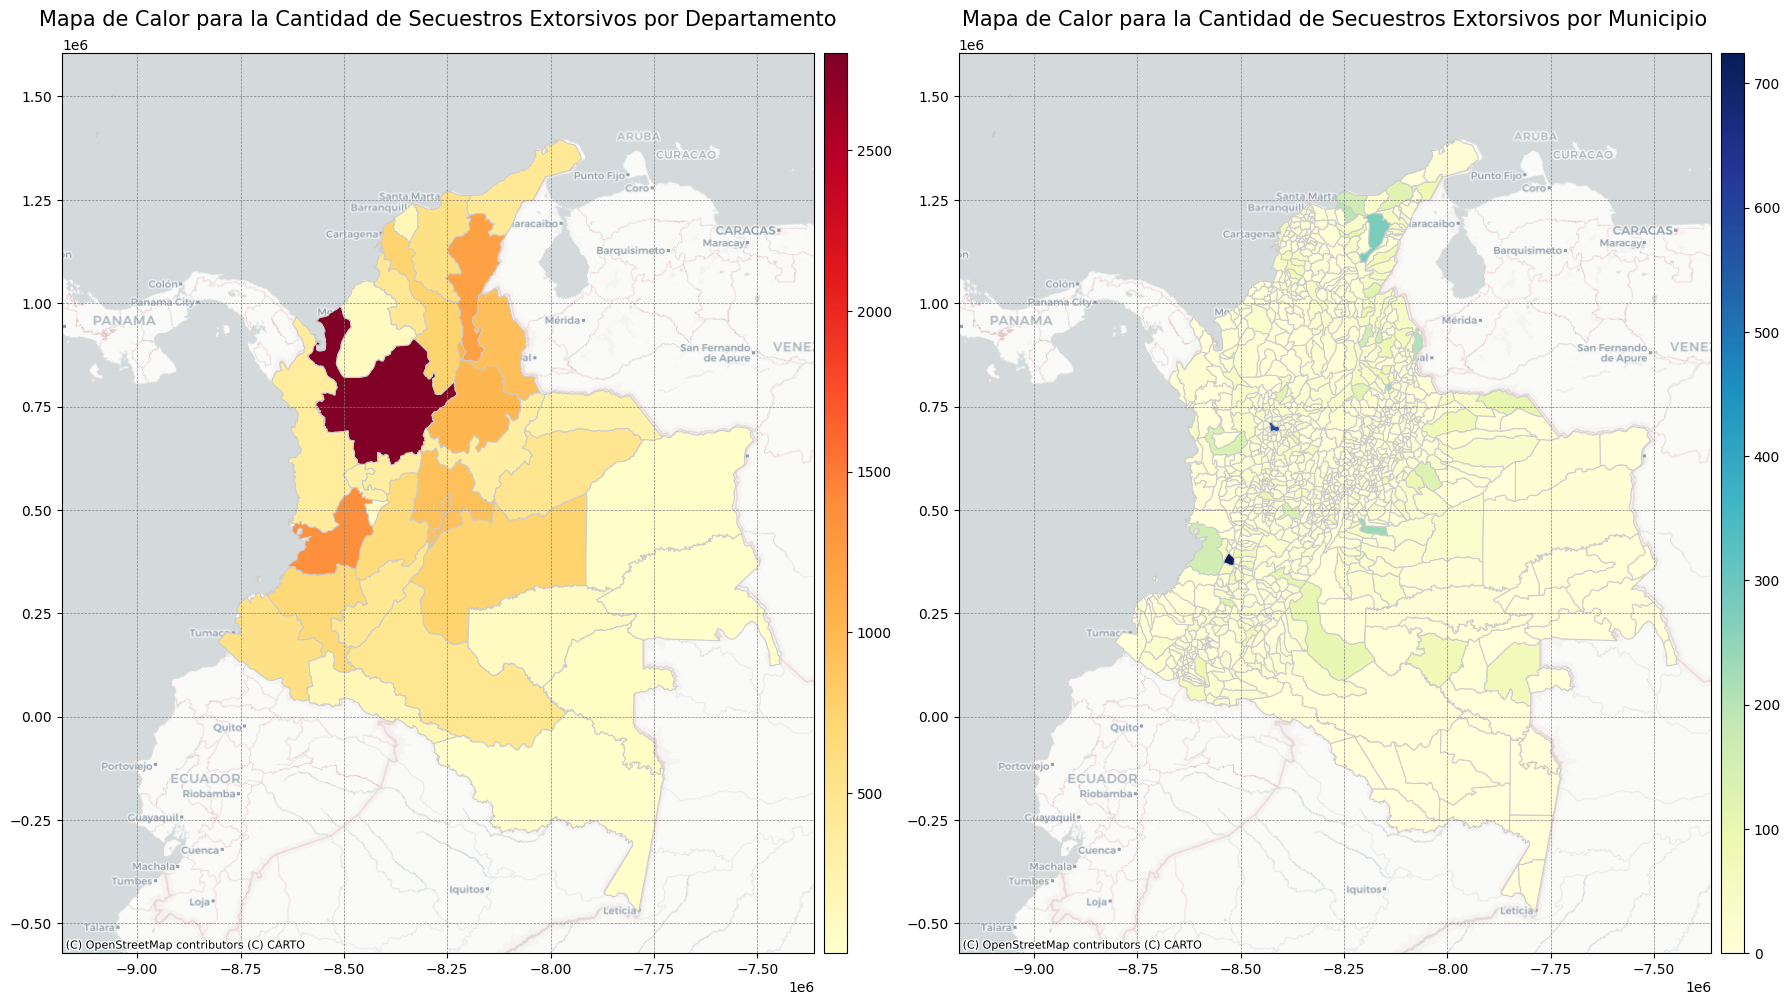

In [195]:
mapa_secuestros_tipo(gdf_dept1 , gdf_muni1 , 'N_EXTORSIVO')

The map of extortive kidnappings shows a distribution very similar to that of total kidnappings, with the Andean departments (Antioquia, Valle del Cauca, Bogotá D.C., Santander, and Cesar) displaying even more reddish tones on average, indicating a higher concentration of extortive kidnappings in that region. At the municipal level, the same dark hotspots stand out in departmental capitals, confirming that the extortive modality follows the same geographic pattern as the overall cases.  



## We graph the number of kidnappings for simple motive by municipalities and departments

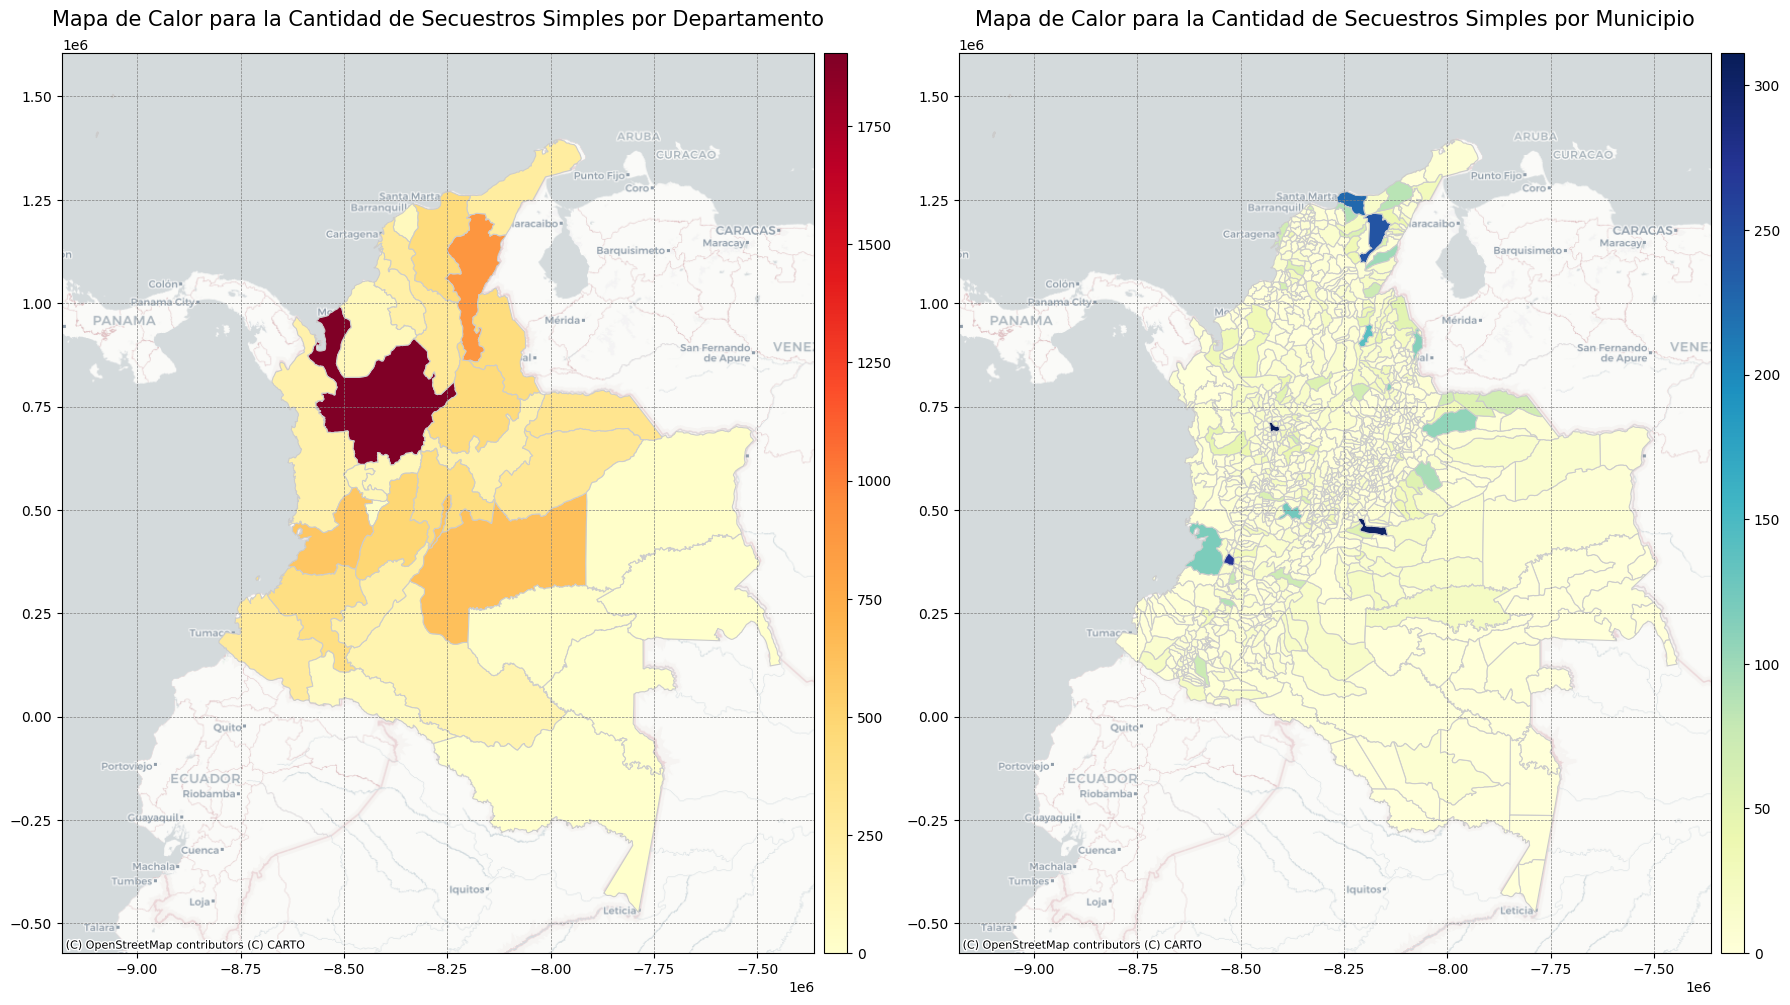

In [196]:
mapa_secuestros_tipo(gdf_dept1 , gdf_muni1 , 'N_SIMPLE')

On the map of simple kidnappings, the overall intensity is lower than in the total or extortive maps, but Meta stands out with a more pronounced reddish hue, highlighting its significance in this modality. At the municipal level, several key municipalities for simple kidnappings are now more clearly distinguishable, especially in the northeastern Caribbean zone, where multiple municipalities show high counts. This suggests that simple kidnappings, although less concentrated, have spread into new hotspots—particularly in the northern region and the northern part of the plains.  



## **Exploratory Analysis Conclusion**

The initial study of the kidnapping series in Colombia—disaggregated into monthly and annual panels and mapped geographically by municipalities and departments—confirms a strongly marked historical dynamic: a massive incidence peak in the late ’90s and early 2000s, followed by a sustained decline from 2002 until stabilization at low levels from 2010 onward. Geographically, a small group of departments (Antioquia, Valle del Cauca, Cesar, Meta, and parts of the Caribbean region) account for the majority of cases, with only certain capitals and rural areas explaining most municipal kidnappings. Creating dummy variables for simple and extortive kidnappings also revealed that extortive incidents follow the same spatial pattern, whereas simple kidnappings stand out notably in Meta and have spread into new regional hotspots. These results establish a solid foundation for incorporating explanatory variables, which we will address in the next script.  



## **Pablo Reyes**